<a href="https://colab.research.google.com/github/msoley/CSCI-535/blob/main/Bias_reduction_posthoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This is taken from https://github.com/dssg/fairness_tutorial

# Addressing Bias and Fairness in Machine Learning: A Practical Guide and Hands-on Tutorial
## KDD 2023 Hands-on Tutorial
### Rayid Ghani, Kit Rodolfa, Pedro Saleiro, Sérgio Jesus

# <font color=red>Exploring Bias Reduction Strategies</font>

## 1. Install dependencies, import packages and data
This is needed every time you open this notebook in **colab** to install dependencies

In [1]:
!pip install pandas==1.5.3

In [2]:
# packages not installed in colab
!pip install pandas==1.5.3
!pip install aequitas==0.42.0
!pip install fairlearn==0.4.6
!pip install hyperparameter-tuning
!pip install fairgbm==0.9.14

import yaml
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import fairlearn
import warnings
warnings.filterwarnings("ignore")
sns.set()
DPI = 200
DATAPATH = 'https://github.com/dssg/fairness_tutorial/raw/master/data/'

## What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics.

As described earlier, the goal here is to select top 1000 project submissions that are likely to not get funded in order to prioritize resource allocation. That corresponds to the metric **Precision at top 1000**.

### <font color=red>We audited the "best" model at precision at top 1000 and found that it has disparities for True Positive Rate for all attributes that we care about (poverty_level of the school, sex, and school_location_type)</font>


In [3]:
evals_df = pd.read_csv(DATAPATH +'split2_evals.csv.gz', compression='gzip')
# Let's sort the models by Precision at top 1000 predicted positives (our performance metric of interest for this case study)
evals_df.sort_values('model_precision', ascending = False)

,model_precision,model_classpath,hyperparameters,model_uuid,predictions_uuid,target_pp,matrix_type,matrix_start_date,matrix_end_date
0,0.552,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,test,2012-12-01,2013-01-31
1,0.551,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,test,2012-12-01,2013-01-31
2,0.550,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",8823d053f9fbe6c34efdae3a2f24c39c,5e78e49f70fac0193eaadb8513428f23,1000,test,2012-12-01,2013-01-31
3,0.549,lightgbm.LGBMClassifier,"{""n_jobs"": -1, ""max_depth"": 2, ""num_leaves"": 5...",ffc7abef4fe933b0f0cfed63d5d03910,f04edad1446642411085e84271898506,1000,test,2012-12-01,2013-01-31
4,0.548,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",110d892ce37127a79d7c6e0eac9a5d13,09092f371176a13cddca59bac20da4fd,1000,test,2012-12-01,2013-01-31
...,...,...,...,...,...,...,...,...,...
395,0.373,sklearn.neural_network.MLPClassifier,"{""alpha"": 0.00009627719435096597, ""beta_1"": 0....",b52e7837725a5a34544c10297256fc81,6020b409648f794f6f55ed235924afe3,1000,test,2012-12-01,2013-01-31
396,0.372,sklearn.neural_network.MLPClassifier,"{""alpha"": 0.000022779312051721987, ""beta_1"": 0...",e79173c1595bc2ba28edee0c01467fa9,b16ad6b2a7eba2e6ba30c14981ebaf3b,1000,test,2012-12-01,2013-01-31
397,0.371,sklearn.neural_network.MLPClassifier,"{""alpha"": 0.0000629250653559928, ""beta_1"": 0.9...",5423f461c575db9934e52b49c2aabf0f,ca1c9b8e742db3761a660cac81a19102,1000,test,2012-12-01,2013-01-31
398,0.364,lightgbm.LGBMClassifier,"{""n_jobs"": -1, ""max_depth"": 14, ""num_leaves"": ...",853e04831b0a855f22f4bd46b995223c,3e9271171981a27f976a9ef8c739cad0,1000,test,2012-12-01,2013-01-31


## Load pre-computed Aequitas audit results

The `aequitas_df` contains a table with the bias audit results for the 400 models for all the attributes we care about (we pre-selected the metrics of interest for this tutorial).

In [4]:
aequitas_df = pd.read_csv(DATAPATH + 'split2_aequitas.csv.gz', compression='gzip')
aequitas_df.head(10)

,model_uuid,predictions_uuid,k,attribute_name,attribute_value,tpr,tpr_disparity,tpr_ref_group_value,pp,tp,group_label_pos,prev,group_size,matrix_type,matrix_start_date,matrix_end_date
0,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,suburban_rural,0.139156,1.000000,suburban_rural,626,333,2393,0.367814,6506,test,2012-12-01,2013-01-31
1,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,urban,0.042674,0.306665,suburban_rural,192,120,2812,0.308502,9115,test,2012-12-01,2013-01-31
2,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,teacher_sex,female,0.102390,3.370670,male,951,527,5147,0.341019,15093,test,2012-12-01,2013-01-31
3,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,poverty_level,lower,0.137859,1.000000,lower,753,394,2858,0.370976,7704,test,2012-12-01,2013-01-31
4,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,poverty_level,highest,0.050771,0.368285,lower,247,158,3112,0.312043,9973,test,2012-12-01,2013-01-31
5,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,teacher_sex,male,0.030377,1.000000,male,49,25,823,0.318498,2584,test,2012-12-01,2013-01-31
6,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,poverty_level,lower,0.149405,1.000000,lower,805,427,2858,0.370976,7704,test,2012-12-01,2013-01-31
7,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,poverty_level,highest,0.039846,0.266696,lower,195,124,3112,0.312043,9973,test,2012-12-01,2013-01-31
8,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,teacher_sex,female,0.101613,2.986684,male,944,523,5147,0.341019,15093,test,2012-12-01,2013-01-31
9,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,teacher_sex,male,0.034022,1.000000,male,56,28,823,0.318498,2584,test,2012-12-01,2013-01-31


Combining the `evals_df` with the `aequitas_df` allow us to get a clearer picture how the different models compare with each other in both performance and bias of our groups of interest.

The `create_scatter_disparity_performance` method will help us to easily plot the 400 models bias-performance tradeoffs and it's going to be used throughout the notebook.

In [5]:
def create_scatter_disparity_performance(evals_df, aequitas_df,  attr_col, group_name,
                                         performance_col='model_precision', bias_metric='tpr', flip_disparity=False,
                                         mitigated_tags=[], mitigated_bdfs=[], mitigated_performances=[], ylim=None):
    disparity_df = aequitas_df.loc[(aequitas_df['attribute_name']==attr_col) & (aequitas_df['attribute_value']==group_name)].copy()
    disparity_metric = bias_metric + '_disparity'
    scatter_schema = ['model_uuid', performance_col, 'attribute_name', 'attribute_value', bias_metric, disparity_metric, 'model_tag']
    if flip_disparity:
        disparity_df[disparity_metric]= disparity_df.apply(lambda x: 1/x[disparity_metric] , axis=1)
    scatter = pd.merge(evals_df, disparity_df, how='left', on=['model_uuid'], sort=True, copy=True)
    scatter = scatter[['model_uuid', performance_col, 'attribute_name', 'attribute_value', bias_metric, disparity_metric]].copy()
    scatter['model_tag'] = 'Other Models'
    scatter.sort_values('model_precision', ascending = False, inplace=True, ignore_index=True)
    scatter['model_tag'] = scatter.apply(lambda x: 'Highest Precision at 1000' if int(x.name) < 1 else x['model_tag'], axis=1)
    mitigated_points = []
    scatter_final = pd.DataFrame()
    if mitigated_bdfs and mitigated_performances:
        for i in range(len(mitigated_bdfs)):
            if not mitigated_bdfs[i].empty and mitigated_performances[i] !=None:
                mitigated_bdfs[i][performance_col] = mitigated_performances[i]
                mitigated_bdfs[i]['model_tag'] = mitigated_tags[i]
                new_disparity_df = mitigated_bdfs[i].loc[(mitigated_bdfs[i]['attribute_name']==attr_col) & (mitigated_bdfs[i]['attribute_value']==group_name)].copy()
                if flip_disparity:
                    new_disparity_df[disparity_metric]= new_disparity_df.apply(lambda x: 1/x[disparity_metric] , axis=1)
                scatter_new = new_disparity_df[[c for c in new_disparity_df.columns if c in scatter_schema]].copy()
                mitigated_points.append(scatter_new)
        scatter_final = pd.concat(mitigated_points , axis=0)

    ax = sns.scatterplot(
        x='model_precision', y=disparity_metric, hue='model_tag',
        data=scatter,
        alpha=0.4, s=20, palette = np.array(sns.color_palette()[0:2])


    )
    if not scatter_final.empty:
        ax1 = sns.scatterplot(
            x='model_precision', y=disparity_metric, hue='model_tag',
            data=scatter_final,
            alpha = 0.95, s=20,  palette = np.array(sns.color_palette()[2:3] + sns.color_palette()[4:])
        )

    if ylim:
        plt.ylim(0, 10)
    flip_placeholder = 'Flipped' if flip_disparity else ''
    ax.set_title('{} {} vs.{} for {}:{}'.format(flip_placeholder, disparity_metric, performance_col, attr_col,group_name ), y=1., fontsize='xx-small')
    #plt.gcf().set_size_inches((4, 3))
    plt.legend(loc='upper left', fontsize='xx-small', prop={'size': 5})
    plt.gcf().set_dpi(DPI)
    plt.show()

# Bias Reduction Strategies
We can try a few different bias reduction strategies now and compare the audit results with the original models. Let's try Post-hoc adjustment


In [6]:
# We will first load the dataset
traindf = pd.read_csv(DATAPATH + 'train_20120501_20120801.csv.gz', compression='gzip')
testdf = pd.read_csv(DATAPATH + 'test_20121201_20130201.csv.gz', compression='gzip')
train_attrdf = pd.read_csv(DATAPATH + 'train_20120501_20120801_protected.csv.gz', compression='gzip')
test_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

In [7]:
#Let's load the hyperparameters of the highest performance model to a dictionary
import ast
hyperparameters= ast.literal_eval(evals_df['hyperparameters'][0])

In [8]:
# Since the model with highest performance is a RandomForestClassifier let's create a classifier with the fetched hyperparameters
rf = RandomForestClassifier(**hyperparameters)

### Defining label, group of interest and reference group for the attribute column we care about


In [9]:
label_col = 'quickstart_label'
attribute_col = 'poverty_level'

group_of_interest = 'highest'
reference_group = 'lower'

### Look at training data distributions

#### Poverty_level=Highest
label_pos_poverty_highest =  P(poverty_level=highest | not_funded)

label_neg_poverty_highest =  P(poverty_level=highest | funded)


#### Poverty_level=Lower
label_pos_poverty_lower =  P(poverty_level=lower | not_funded)

label_neg_poverty_lower =  P(poverty_level=lower | funded)


In [10]:
train_attrdf[attribute_col].value_counts()

highest    9448
lower      7342
Name: poverty_level, dtype: int64

In [11]:
traindf

,entity_id,as_of_date,project_features_entity_id_all_grade_level_Grades35_sum,project_features_entity_id_all_grade_level_Grades68_sum,project_features_entity_id_all_grade_level_Grades912_sum,project_features_entity_id_all_grade_level_GradesPreK2_sum,project_features_entity_id_all_grade_level__NULL_sum,project_features_entity_id_all_resource_type_Books_sum,project_features_entity_id_all_resource_type_Other_sum,project_features_entity_id_all_resource_type_Supplies_sum,...,donation_features_entity_id_all_zip_avg_donations_2yr_imp,donation_features_entity_id_all_zip_funding_rate_1yr_sum,donation_features_entity_id_all_zip_funding_rate_1yr_imp,donation_features_entity_id_all_zip_funding_rate_2yr_sum,donation_features_entity_id_all_zip_funding_rate_2yr_imp,quickstart_label,project_features_entity_id_all_poverty_level_highpoverty,project_features_entity_id_all_poverty_level_highestpoverty,project_features_entity_id_all_poverty_level_lowpoverty,project_features_entity_id_all_poverty_level_moderatepoverty
0,251733,1335913200000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.588235,0.0,0.619048,0.0,0.0,0.0,1.0,0.0,0.0
1,251734,1335913200000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.927536,0.0,0.785714,0.0,0.0,0.0,0.0,1.0,0.0
2,251735,1335913200000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.666667,0.0,0.750000,0.0,0.0,0.0,1.0,0.0,0.0
3,251736,1335913200000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.678571,0.0,0.625000,0.0,0.0,0.0,1.0,0.0,0.0
4,251737,1335913200000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.714286,0.0,0.793103,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16785,235210,1343775600000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.703704,0.0,0.782609,0.0,0.0,0.0,1.0,0.0,0.0
16786,235211,1343775600000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.680000,0.0,0.612245,0.0,1.0,0.0,1.0,0.0,0.0
16787,235212,1343775600000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.666667,0.0,0.461538,0.0,0.0,0.0,1.0,0.0,0.0
16788,235204,1343775600000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.738462,0.0,0.686747,0.0,1.0,0.0,1.0,0.0,0.0


In [12]:
def get_group_stats(df, attrdf, label_col, attribute_col, group_name):
    """Calculates group-wise stats: prevalence, group_size, num label pos, num label neg
       Returns: prevalence, group_size, df of group label pos, df of group label neg
    """
    group_size = len(df.loc[attrdf[attribute_col]==group_name])
    label_pos = df.loc[(attrdf[attribute_col]==group_name) & (df[label_col] > 0)].copy()
    label_neg = df.loc[(attrdf[attribute_col]==group_name) & (df[label_col] < 1.0)].copy()
    assert (group_size == len(label_pos) + len(label_neg)), "label pos + label neg is different from group size!"
    prev = len(label_pos) / group_size
    print("{} == '{}'\n\t group size: {} \n\t prevalence: {:.3f}".format(attribute_col,group_name, group_size, prev))
    return prev, group_size, label_pos, label_neg

In [13]:
_ = get_group_stats(traindf, train_attrdf, label_col, attribute_col, group_of_interest)

poverty_level == 'highest'
	 group size: 9448 
	 prevalence: 0.338


In [14]:
_ = get_group_stats(traindf, train_attrdf, label_col, attribute_col, reference_group)

poverty_level == 'lower'
	 group size: 7342 
	 prevalence: 0.426


In [15]:
print('Recapping the group of interest and reference we defined above: \n\n Attribute: {}\n Group of interest: {}\n Reference Group: {}'.format(attribute_col, group_of_interest, reference_group))

Recapping the group of interest and reference we defined above: 

 Attribute: poverty_level
 Group of interest: highest
 Reference Group: lower


## Before and After: Run Aequitas


Let's define an audit util method to use throghout the notebook when audit different models.

In [16]:
# This method will help auditing the predictions we made with Aequitas
def aequitas_audit(input_df, ref_groups_dict):
    g = Group()
    b = Bias()
    xtab, _ = g.get_crosstabs(input_df[['score','label_value'] + list(ref_groups_dict.keys())].copy())
    bdf = b.get_disparity_predefined_groups(xtab, input_df, ref_groups_dict)
    return bdf

#### Define the configurations for running the bias audits:

    - a dictionary for reference groups in the format attribute:group
    - the metrics of interest
    - the fairness threshold (the ratio of each group value compared to reference group on a given metric)

In [17]:
# Definitions for the audit
ref_groups_dict={'poverty_level':'lower', 'metro_type':'suburban_rural', 'teacher_sex':'male'}
attributes = ref_groups_dict.keys()
metrics = ['tpr']
fairness_threshold = 1.3

For reference, let's start with looking at the "best" model we chose in terms of overall precision at 1,000:

#### Now let's start with loading the predictions from the "best" model chosen earlier

## <font color=red>Bias Reduction Strategy: Post-Hoc Disparity Mitigation</font>

### What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. We then used these results to pick a "best" model in terms of performance on the "accuracy" metric we care about: **Precision at the top 1000** (corresponding to our goal of selecting 1000 project submissions that are most likely to not get funded in order to prioritize resource allocation).

When we audited this selected model with Aequitas, however, we found biases across many attributes, including the poverty level of the schools. Here, we explore a method of using post-hoc disparity mitigation to reduce this bias in the selected model.

### <font color=green>Intro to Post-Hoc Bias Mitigation</font>

![Diagram of Post-Hoc Adjustments](post_hoc_adj.png "Post-Hoc Adjustments")

One approach to improving the fairness of our model is to make post-hoc adjustments to the thresholds used for each subgroup to choose the 1,000 projects on which to intervene. Because our fairness metric here (**recall** aka **tpr** aka **equality of opportunity**) is monatonically increasing with the depth of the score, we should be able to find score thresholds for each subgroup that will equalize this metric across the groups, subject to the constraint that we want to choose a total of 1,000 projects for our intervation.

In short, here's how this will work (see the references below for a more detailed discussion):
1. Train the model as usual on a training set, predict scores on a test set
2. Split this test set by subgroups on our protected attribute (here, poverty level)
3. Sort each subgroup by score and calculate the cumulative tpr/recall up to and including each row in the set, storing this "rolling within-subgroup recall" value
4. Recombine the subgroups, and sort the entire set by this new value
5. Take the top 1,000 projects from this re-ordered list and use it to calculate "top k" sizes for each subgroup that equalize recall
6. Then, on a future test set, use these calculated subgroup list sizes to assess the impact of disparities and overall precision

References:
- Hardt, et al, [Equality of Opportunity in Supervised Learning](http://papers.nips.cc/paper/6373-equality-of-opportunity-in-supervised-learning)
- Rodolfa, et al, [Case Study: Predictive Fairness to Reduce Misdemeanor Recidivism Through Social Service Interventions](https://dl.acm.org/doi/abs/10.1145/3351095.3372863?casa_token=zc196JJrqkkAAAAA:bPmqmKrA91esJhIxHPT4K1crWWb5JGcflVFDkTgODctMzLpUX50_56Kyyh4NJ2GTd_QSydqhNpjT)

### Load the train, test, and protected attributes from the first split

In [18]:
split1_traindf = pd.read_csv(DATAPATH + 'train_20111101_20120201.csv.gz', compression='gzip')
split1_testdf = pd.read_csv(DATAPATH + 'test_20120601_20120801.csv.gz', compression='gzip')
split1_attrdf = pd.read_csv(DATAPATH + 'test_20120601_20120801_protected.csv.gz', compression='gzip')

Let's just take a quick look at the data to make sure it makes sense:

In [19]:
split1_traindf.head()

,entity_id,as_of_date,project_features_entity_id_all_grade_level_Grades35_sum,project_features_entity_id_all_grade_level_Grades68_sum,project_features_entity_id_all_grade_level_Grades912_sum,project_features_entity_id_all_grade_level_GradesPreK2_sum,project_features_entity_id_all_grade_level__NULL_sum,project_features_entity_id_all_resource_type_Books_sum,project_features_entity_id_all_resource_type_Other_sum,project_features_entity_id_all_resource_type_Supplies_sum,...,donation_features_entity_id_all_zip_avg_donations_2yr_imp,donation_features_entity_id_all_zip_funding_rate_1yr_sum,donation_features_entity_id_all_zip_funding_rate_1yr_imp,donation_features_entity_id_all_zip_funding_rate_2yr_sum,donation_features_entity_id_all_zip_funding_rate_2yr_imp,quickstart_label,project_features_entity_id_all_poverty_level_highpoverty,project_features_entity_id_all_poverty_level_highestpoverty,project_features_entity_id_all_poverty_level_lowpoverty,project_features_entity_id_all_poverty_level_moderatepoverty
0,313448,1320105600000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.636364,0.0,0.696970,0.0,1.0,1.0,0.0,0.0,0.0
1,313441,1320105600000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.000000,1.0,0.000000,1.0,0.0,0.0,0.0,1.0,0.0
2,313449,1320105600000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.300000,0.0,0.592593,0.0,1.0,1.0,0.0,0.0,0.0
3,313447,1320105600000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.000000,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.0
4,313446,1320105600000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.111111,0.0,0.652174,0.0,0.0,0.0,0.0,0.0,1.0


### Set up some parameters we'll need below

Note that the classifier type and hyperparameters here are from the best-performing model we chose above based on precision on the top 1000.

In [20]:
hyperparameters = {
    'criterion': 'gini',
    'max_depth': 30,
    'max_features': 'sqrt',
    'min_samples_leaf': 44,
    'min_samples_split': 3,
    'n_estimators': 87,
    'n_jobs': -1,
    'random_state': 213500298
}
clf = RandomForestClassifier(**hyperparameters)

top_k = 1000

label_col = 'quickstart_label'
entity_col = 'entity_id'
date_col = 'as_of_date'
exclude_cols = [label_col, entity_col, date_col] # columns to exclude from the X matrices for the classifier

protected_attribute_col = 'poverty_level'

# Parameters for Aequitas

metrics = ['tpr']
disparity_threshold = 1.3
protected_attribute_ref_group = {protected_attribute_col:'lower'}


### Train the model and predict on the test set

In [21]:
# train
y_train = split1_traindf[label_col].values
clf.fit(split1_traindf.drop(exclude_cols, axis = 1), y_train)

# test set predictions
split1_preds = split1_testdf[[entity_col, date_col, label_col]].copy()
split1_preds['predict_proba'] = clf.predict_proba(split1_testdf.drop(exclude_cols, axis = 1))[:,1]

Let's take a quick look at the predictions to make sure they look good:

In [22]:
split1_preds.head()

,entity_id,as_of_date,quickstart_label,predict_proba
0,246363,1338591600000,1.0,0.382485
1,246362,1338591600000,1.0,0.188013
2,246361,1338591600000,0.0,0.398983
3,246360,1338591600000,0.0,0.422042
4,246359,1338591600000,1.0,0.403111


### Combine predictions with protected attributes

In [23]:
df = pd.merge(split1_preds, split1_attrdf, how='left', on=[entity_col,date_col], sort=True, copy=True)

### Sort by score, then split by protected attribute (poverty level)

In [24]:
protected_attribute_groups = df[protected_attribute_col].unique()

In [25]:
df = df.sort_values('predict_proba', ascending=False)
subgroup_dfs = []
for grp in protected_attribute_groups:
    subgroup_dfs.append(df[df[protected_attribute_col]==grp].copy())

### Calculate within-subgroup cumulative recall

Here, we calculate the recall up to and including each row within the highest-poverty and lower-poverty subsets of the test set. Doing this allows us to recombine and sort the sets in a way that will let find recall-equalizing "top k" list sizes for each subgroup.

In [26]:
for subgrp_df in subgroup_dfs:
    subgrp_df['cumsum_recall'] = subgrp_df[label_col].cumsum() / subgrp_df[label_col].sum()

### Recombine the subgroup sets and sort by this cumulative recall

In [27]:
recall_df = pd.concat(subgroup_dfs, axis=0).sort_values('cumsum_recall', ascending=True)

### Find subgroup sizes, holding the overall list size (1000) constant

Now we can simply threshold this re-sorted list by `top_k` (here, 1000) to identify how many individuals from each group we should apply in the future.

Notice here that each subgroup will still be ordered by their predicted score, but the scores will no longer be perfectly ordered across subgroups.

In [28]:
new_pp = recall_df.head(top_k).copy()
new_pp.tail()

,entity_id,as_of_date,quickstart_label,predict_proba,poverty_level,teacher_sex,metro_type,cumsum_recall
1830,236962,1343343600000,0.0,0.423424,highest,female,urban,0.137341
1695,236827,1343430000000,1.0,0.470249,lower,female,suburban_rural,0.137405
6585,241717,1341183600000,1.0,0.423386,highest,female,suburban_rural,0.137780
9908,245042,1339455600000,0.0,0.470204,lower,female,suburban_rural,0.137882
1226,236358,1343516400000,1.0,0.470228,lower,female,suburban_rural,0.137882


In [29]:
new_pp[protected_attribute_col].value_counts()

highest    554
lower      446
Name: poverty_level, dtype: int64

Let's just store this to re-use below:

In [30]:
subgroup_k = {}
for grp in protected_attribute_groups:
  subgroup_k[grp] = new_pp[protected_attribute_col].value_counts()[grp]

### Apply these subgroup-specific sizes to future test set data

Now we have calculated the number of projects we need to select from each poverty level, we can apply these to the most recent split to assess how well this method reduces the recall disparities we saw initially and whether this has any impact on the overall precision of the model.

### Load the predictions and protected attributes from the future test set

Note that the predictions here correspond to the same model + hyperparameters we specified above

In [31]:
split2_preds = pd.read_csv(DATAPATH + 'predictions_c598fbe93f4c218ac7d325fb478598f1.csv.gz', compression='gzip')
split2_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

df2 = pd.merge(split2_preds, split2_attrdf, how='left', on=[entity_col, date_col], sort=True, copy=True)

Take a quick look to make sure the data loaded without any issue:

In [32]:
df2.head()

,entity_id,as_of_date,quickstart_label,predict_proba,poverty_level,teacher_sex,metro_type
0,119,1359504000000,0.0,0.364484,lower,female,suburban_rural
1,120,1359158400000,0.0,0.347160,highest,female,unknown
2,121,1358812800000,1.0,0.503259,lower,female,suburban_rural
3,122,1358726400000,0.0,0.442060,lower,female,unknown
4,123,1358726400000,0.0,0.325577,lower,female,urban


### Split the test set by poverty level to apply the thresholds

In [33]:
df2 = df2.sort_values('predict_proba', ascending=False)
new_subgroup_dfs = {}
for grp in protected_attribute_groups:
    new_subgroup_dfs[grp] = df2[df2[protected_attribute_col]==grp].copy()

### Choose the number of projects from each subgroup found above

Notice here that we're choosing the "top k" individuals within each subgroup based on their predicted score -- in a deployment, we wouldn't know the true labels to calculate recall values, which is why we had to go one step back in time to find these group sizes.

In [34]:
pp_dfs = []
for grp in protected_attribute_groups:
    pp_dfs.append(new_subgroup_dfs[grp].head(subgroup_k[grp]))

### Recombine and create a predicted class label for this resulting set
That is, 1,000 projects with a label 1 chosen by this process and 0 otherwise

In [35]:
new_pp2 = pd.concat(pp_dfs, axis=0).sort_values('predict_proba', ascending=True)

mitigated_df = df2.copy()
mitigated_df = mitigated_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas

# create a "score" column with the predicted class (named "score" for use with Aequitas below)
mitigated_df['score'] = mitigated_df.apply(lambda x: 1.0 if x.name in new_pp2.index.tolist() else 0, axis=1)

for comparison, let's also look at the unmitigated result again...

In [36]:
unadjusted_df = df2.sort_values('predict_proba', ascending=False).copy()
unadjusted_df = unadjusted_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas

# create a "score" column with the predicted class (named "score" for use with Aequitas below)
unadjusted_df['score'] = unadjusted_df.apply(lambda x: 1.0 if x.name in unadjusted_df.head(top_k).index.tolist() else 0, axis=1)

### Running Aequitas - Before and After

#### For the original score, without post-hoc adjustment for equity

In [37]:
bdf_unadjusted = aequitas_audit(unadjusted_df, protected_attribute_ref_group)
ap.disparity(bdf_unadjusted, metrics, protected_attribute_col, fairness_threshold=disparity_threshold)

get_disparity_predefined_group()


alt.LayerChart(...)

#### For the score, with post-hoc disparity mitigation

In [38]:
bdf_mitigated = aequitas_audit(mitigated_df, ref_groups_dict)

ap.disparity(bdf_mitigated, metrics, protected_attribute_col, fairness_threshold=disparity_threshold)

get_disparity_predefined_group()


alt.LayerChart(...)

So, it looks the post-hoc adjustments have actually manage to mitigate the existing disparity pretty well (perhaps even over-shooting somewhat, though still within our fairness threshold of 1.3).

However, the natural question here is where there is a fairness-accuracy trade-off here: What cost did we incur in terms of model performance, that is overall precision?

#### Before: Precision of the original, unadjusted score

In [39]:
unadjusted_df.loc[unadjusted_df['score']==1]['label_value'].mean()

0.552

#### After: Precision of the new, disparity-mitigated score

In [40]:
mitigated_df.loc[mitigated_df['score']==1]['label_value'].mean()

0.581

Somewhat surprisingly, we actually don't seem to see any trade-off with the disparity mitigation here!

### Adding to the model selection (tradeoff) graph

Finally, let's look at how this new option stacks up against the other models

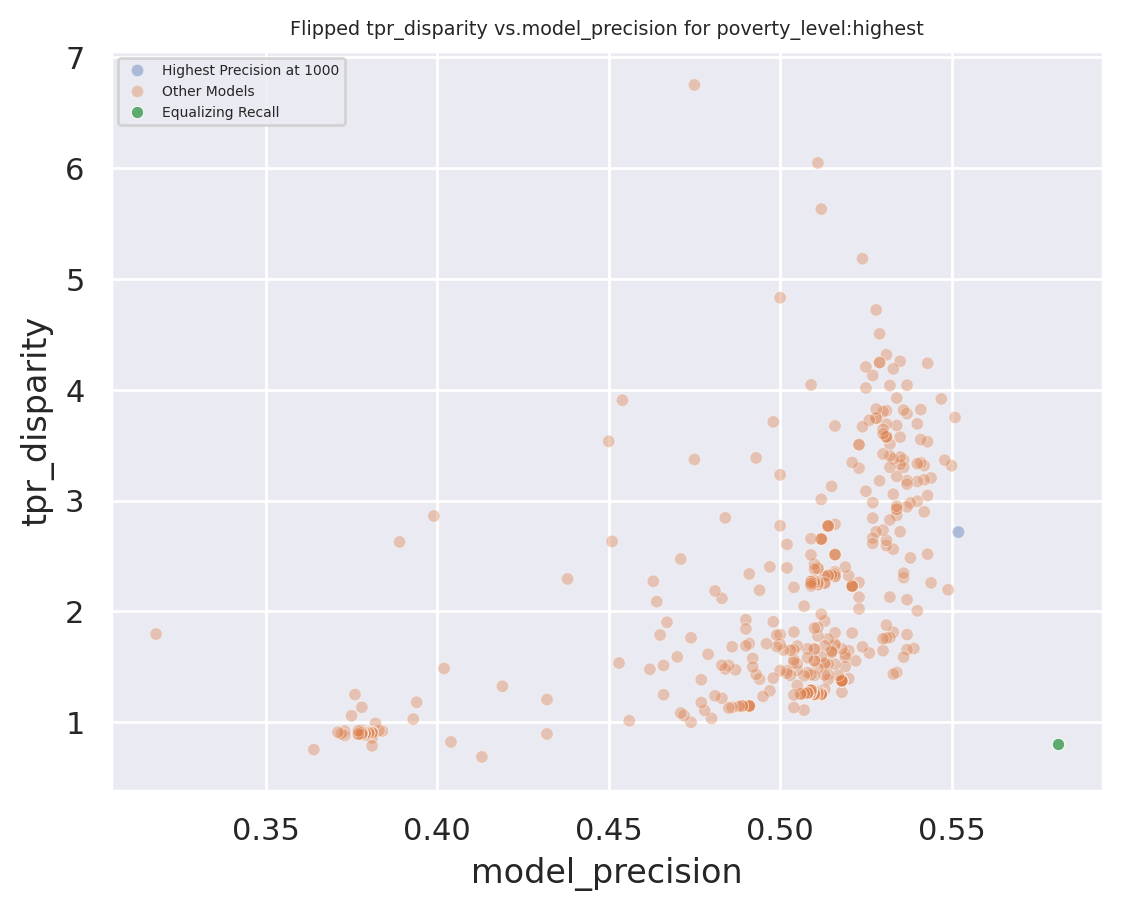

In [41]:
mitigated_precision_6 = mitigated_df.loc[mitigated_df['score']==1]['label_value'].mean()
plot_configs = {
    'evals_df':evals_df,
    'aequitas_df':aequitas_df,
    'attr_col':'poverty_level',
    'group_name':'highest',
    'performance_col':'model_precision',
    'bias_metric':'tpr',
    'flip_disparity':True,
    'mitigated_tags':['Equalizing Recall'],
    'mitigated_bdfs':[bdf_mitigated],
    'mitigated_performances':[mitigated_precision_6],
    'ylim':None
}
create_scatter_disparity_performance(**plot_configs)